In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [125]:
training_set = pd.read_csv('data/dam.csv', parse_dates=True, index_col=0)
dataset = pd.read_csv('data/dam.csv', parse_dates=True, index_col=0)
training_set = training_set.iqty.values

In [10]:
training_set

array([ 18.9,  18. ,  20.4, ..., 278.2, 291.9,  35.6])

In [55]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

class SlidingWindowDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length, transform=None, train=True):
        if train == True:
            data = data[:int(len(data)*0.67)]
        else:
            data = data[int(len(data)*0.67):]
        self.cs = MinMaxScaler()
        if transform:
            data = cs.fit_transform(data.reshape(-1, 1)).reshape(-1)
        
        self.x, self.y = sliding_windows(data, seq_length)
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def transform(data):
    return (data - np.min(data))/(np.min(data) - np.max(data))

train_dataset = SlidingWindowDataset(training_set, 4, transform=True, train=True)
test_dataset = SlidingWindowDataset(training_set, 4, transform=True, train=False)

# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

# seq_length = 4
# x, y = sliding_windows(training_data, seq_length)

# train_size = int(len(y) * 0.67)
# test_size = len(y) - train_size

# dataX = Variable(torch.Tensor(np.array(x)))
# dataY = Variable(torch.Tensor(np.array(y)))

# trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
# trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
# testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [57]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [70]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set.reshape(-1, 1)).reshape(-1)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [105]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([6977, 4]),
 torch.Size([6977]),
 torch.Size([3437, 4]),
 torch.Size([3437]))

In [112]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [130]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX.unsqueeze(-1))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.unsqueeze(-1))
    
    loss.backward()
    
    optimizer.step()
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.30540
Epoch: 1, loss: 0.27689
Epoch: 2, loss: 0.25095
Epoch: 3, loss: 0.22740
Epoch: 4, loss: 0.20602
Epoch: 5, loss: 0.18659
Epoch: 6, loss: 0.16890
Epoch: 7, loss: 0.15274
Epoch: 8, loss: 0.13792
Epoch: 9, loss: 0.12429
Epoch: 10, loss: 0.11170
Epoch: 11, loss: 0.10004
Epoch: 12, loss: 0.08921
Epoch: 13, loss: 0.07915
Epoch: 14, loss: 0.06980
Epoch: 15, loss: 0.06113
Epoch: 16, loss: 0.05308
Epoch: 17, loss: 0.04566
Epoch: 18, loss: 0.03883
Epoch: 19, loss: 0.03258
Epoch: 20, loss: 0.02692
Epoch: 21, loss: 0.02184
Epoch: 22, loss: 0.01733
Epoch: 23, loss: 0.01340
Epoch: 24, loss: 0.01004
Epoch: 25, loss: 0.00725
Epoch: 26, loss: 0.00503
Epoch: 27, loss: 0.00334
Epoch: 28, loss: 0.00218
Epoch: 29, loss: 0.00150
Epoch: 30, loss: 0.00124
Epoch: 31, loss: 0.00134
Epoch: 32, loss: 0.00171
Epoch: 33, loss: 0.00227
Epoch: 34, loss: 0.00290
Epoch: 35, loss: 0.00353
Epoch: 36, loss: 0.00407
Epoch: 37, loss: 0.00447
Epoch: 38, loss: 0.00470
Epoch: 39, loss: 0.00475
Epoch: 40,

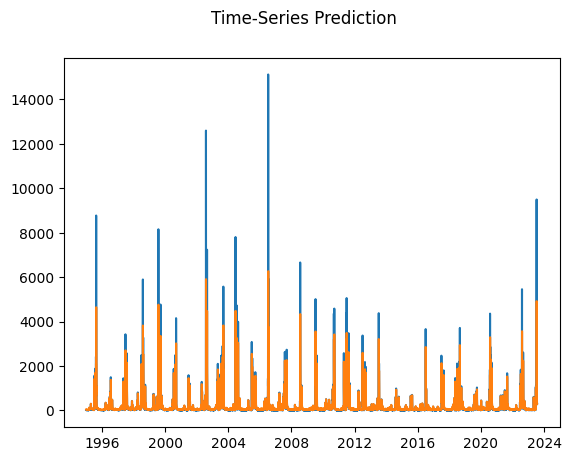

In [131]:
lstm.eval()
train_predict = lstm(dataX.unsqueeze(-1))

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot.reshape(-1, 1)).reshape(-1)

plt.plot(dataset.index[:-5],dataY_plot)
plt.plot(dataset.index[:-5],data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [128]:
dataset.index

DatetimeIndex(['1995-01-01', '1995-01-02', '1995-01-03', '1995-01-04',
               '1995-01-05', '1995-01-06', '1995-01-07', '1995-01-08',
               '1995-01-09', '1995-01-10',
               ...
               '2023-07-17', '2023-07-18', '2023-07-19', '2023-07-20',
               '2023-07-21', '2023-07-22', '2023-07-23', '2023-07-24',
               '2023-07-25', '2023-07-26'],
              dtype='datetime64[ns]', name='obsymd', length=10419, freq=None)

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mean_squared_error(dataY_plot, data_predict), mean_absolute_error(dataY_plot, data_predict), r2_score(dataY_plot, data_predict)

(114459.055, 78.30774, 0.5118977771178583)

In [144]:
def nash_sutcliffe_efficiency(observed, simulated):
    """
    Computes the Nash-Sutcliffe efficiency coefficient for two arrays of data.

    Args:
        observed (array-like): Array of observed data.
        simulated (array-like): Array of simulated data.

    Returns:
        float: Nash-Sutcliffe efficiency coefficient.
    """
    numerator = np.sum((observed - simulated)**2)
    denominator = np.sum((observed - np.mean(observed))**2)
    efficiency = 1 - (numerator / denominator)
    return efficiency

In [148]:
dataY_plot.shape, data_predict.reshape(-1).shape

((10414,), (10414,))

In [149]:
nash_sutcliffe_efficiency(dataY_plot, data_predict.reshape(-1))

0.5118978321552277

In [150]:
import scipy.stats as stats
norm = stats.norm(1, 1.5)
p_i = norm.rvs(size=(12,4))
p_i

array([[ 1.68308493, -0.01257429,  0.40839098, -3.27368332],
       [-1.53349012,  2.74708559, -2.71117605, -0.04302748],
       [ 0.4656978 , -0.84953347,  0.30759746, -0.94628295],
       [ 0.85249619, -0.63380142,  1.6703447 ,  2.01706608],
       [ 0.1701919 ,  0.85083572, -0.44066757, -0.36096388],
       [ 1.81225441,  1.84118726,  1.08173252,  2.41315157],
       [ 1.00513727,  0.30242971,  0.20121355,  0.55338605],
       [ 1.2197073 , -1.42816422,  0.26673799, -0.35976495],
       [-0.53663279,  0.44221219, -1.0415123 ,  1.99322231],
       [ 2.27109721,  2.56012587,  2.26366149, -0.10751769],
       [ 2.31989392,  1.31938358,  1.06706186,  2.00202746],
       [ 0.08304784,  1.91176447, -0.68570487,  0.0038865 ]])

In [151]:
df = pd.DataFrame(data = p_i, columns=['RMSE', 'BS', 'RES', 'WD'])

In [152]:
df

,RMSE,BS,RES,WD
0,1.683085,-0.012574,0.408391,-3.273683
1,-1.533490,2.747086,-2.711176,-0.043027
2,0.465698,-0.849533,0.307597,-0.946283
3,0.852496,-0.633801,1.670345,2.017066
4,0.170192,0.850836,-0.440668,-0.360964
5,1.812254,1.841187,1.081733,2.413152
6,1.005137,0.302430,0.201214,0.553386
7,1.219707,-1.428164,0.266738,-0.359765
8,-0.536633,0.442212,-1.041512,1.993222
9,2.271097,2.560126,2.263661,-0.107518


In [160]:
df.median()

RMSE    0.928817
BS      0.646524
RES     0.287168
WD     -0.019570
dtype: float64

In [177]:
def fr(a):
  b = np.roll(a,1)
  b = np.delete(b,0)
  a = np.delete(a,0)
  return a - b

def freq_analysis(grid): 
  df2 = grid
  df3 = (df2 < -2.5)
  arr = np.zeros_like(grid, dtype = object)

  for i in range(len(df3)):
    
    if (df3[i] == True) and (df3[i-1] == False):
      if i == 0:
        pass
      else:
        arr[i] = "start"
    elif (df3[i] == False) and (df3[i-1] == True):
      if np.count_nonzero(arr[:i]) != 0:
        arr[i] = "end"

  if np.array(*np.where(arr == "start"))[-1] > np.array(*np.where(arr == "end"))[-1]:
      if arr[-1] == 0:
          arr[-1] = "end"
      else:
          arr[-1] = 0 

  duration = np.array(*np.where(arr == "end")) - np.array(*np.where(arr == "start"))
  start_mask = arr == "start"
  return arr , duration, np.array(*np.where(arr == "start")) , np.array(*np.where(arr == "end")) , fr(np.array(*np.where(arr == "start"))), start_mask


In [174]:
sample = np.random.normal(0,2,100)
sample

array([ 1.02678289,  1.63980747,  2.73092619,  1.26031049, -0.97383875,
       -1.21672029,  4.30368567, -2.1148422 ,  0.18734134,  0.48596759,
       -4.90305821,  3.73905729,  3.60092871, -2.03358187,  1.44839154,
       -4.33465688, -2.95006163, -1.56825012,  1.48593169, -2.46037468,
       -2.20202234, -1.99445006, -2.17713654,  2.83768004,  0.31667276,
       -0.24564217, -1.16677338, -1.36003318, -0.52421743,  1.6522544 ,
        1.66277558, -0.06352589, -0.31830446, -0.25793872,  0.2370784 ,
        6.87272329, -2.75580687,  2.37607441,  2.21790458,  0.47815617,
        0.48053354, -0.87778507,  0.12584756, -4.37038411,  1.58683814,
       -1.25008118, -0.69780278, -0.0818493 ,  0.71105751,  0.28151551,
        0.30193935, -0.1177846 ,  4.7152209 , -0.88855454,  0.59514014,
        2.41522414,  0.99995626,  0.04197685, -1.37999816,  4.68930198,
       -0.62626777, -1.20197965,  0.11789474, -0.68748935, -0.05890895,
       -1.29062749, -4.03848228, -1.48668301,  0.46503101, -0.97

In [178]:
a,b,c,d,e,f = freq_analysis(sample)
sum(f), len(e)

(8, 7)

In [179]:
freq_analysis(sample)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'start', 'end', 0, 0, 0, 'start', 0,
        'end', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        'start', 'end', 0, 0, 0, 0, 0, 'start', 'end', 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'start', 'end', 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'start', 0, 'end', 0, 0,
        'start', 'end', 0, 0, 0, 0, 'start', 'end', 0, 0, 0, 0],
       dtype=object),
 array([1, 2, 1, 1, 1, 2, 1, 1], dtype=int64),
 array([10, 15, 36, 43, 66, 83, 88, 94], dtype=int64),
 array([11, 17, 37, 44, 67, 85, 89, 95], dtype=int64),
 array([ 5, 21,  7, 23, 17,  5,  6], dtype=int64),
 array([False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, 

In [171]:
# make sample time period from 2000-01-01 to ~

import datetime
time_period_sample = pd.period_range(start=datetime.datetime(2000,1,1), periods=100, freq="D")
time_period_sample

PeriodIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
             '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
             '2000-01-09', '2000-01-10', '2000-01-11', '2000-01-12',
             '2000-01-13', '2000-01-14', '2000-01-15', '2000-01-16',
             '2000-01-17', '2000-01-18', '2000-01-19', '2000-01-20',
             '2000-01-21', '2000-01-22', '2000-01-23', '2000-01-24',
             '2000-01-25', '2000-01-26', '2000-01-27', '2000-01-28',
             '2000-01-29', '2000-01-30', '2000-01-31', '2000-02-01',
             '2000-02-02', '2000-02-03', '2000-02-04', '2000-02-05',
             '2000-02-06', '2000-02-07', '2000-02-08', '2000-02-09',
             '2000-02-10', '2000-02-11', '2000-02-12', '2000-02-13',
             '2000-02-14', '2000-02-15', '2000-02-16', '2000-02-17',
             '2000-02-18', '2000-02-19', '2000-02-20', '2000-02-21',
             '2000-02-22', '2000-02-23', '2000-02-24', '2000-02-25',
             '2000-02-26', '2000-0

In [172]:
time_period_sample[f]

PeriodIndex(['2000-01-07', '2000-01-13', '2000-01-29', '2000-02-03',
             '2000-02-29', '2000-03-08', '2000-03-22', '2000-03-26',
             '2000-03-29', '2000-04-08'],
            dtype='period[D]')

In [180]:
list(zip(time_period_sample[f], e))

[(Period('2000-01-11', 'D'), 5),
 (Period('2000-01-16', 'D'), 21),
 (Period('2000-02-06', 'D'), 7),
 (Period('2000-02-13', 'D'), 23),
 (Period('2000-03-07', 'D'), 17),
 (Period('2000-03-24', 'D'), 5),
 (Period('2000-03-29', 'D'), 6)]

In [181]:
bucket = np.ndarray(shape=(2,2),dtype=object)
bucket

array([[None, None],
       [None, None]], dtype=object)

In [183]:
bucket[0,0] = list(zip(time_period_sample[f], e))

In [184]:
bucket

array([[list([(Period('2000-01-11', 'D'), 5), (Period('2000-01-16', 'D'), 21), (Period('2000-02-06', 'D'), 7), (Period('2000-02-13', 'D'), 23), (Period('2000-03-07', 'D'), 17), (Period('2000-03-24', 'D'), 5), (Period('2000-03-29', 'D'), 6)]),
        None],
       [None, None]], dtype=object)